# Développement et évaluation de modèles de segmentation d'images

## Objectif
Ce notebook a pour objectif de développer, entraîner et évaluer différents modèles de segmentation d'images dans le cadre d'un système embarqué de vision par ordinateur. Ce travail s'inscrit dans le projet de recherche et développement de Future Vision Transport, visant à concevoir un modèle performant de segmentation qui s'intègre dans une chaîne complète de traitement.

## Détails du projet
Les images du jeu de données utilisées pour ce projet sont annotées avec 32 sous-catégories représentant différents types d'objets et de zones (routes, bâtiments, véhicules, etc.). Afin de réduire la complexité et de répondre aux exigences du système, ces sous-catégories seront regroupées en **8 catégories principales** :
1. **Void** : Zones inutiles ou sans intérêt (par exemple, ciel vide ou éléments indéfinis).
2. **Flat** : Surfaces planes comme les routes et trottoirs.
3. **Construction** : Structures construites telles que les bâtiments et murs.
4. **Objects** : Objets comme les panneaux et poteaux.
5. **Nature** : Éléments naturels tels que les arbres et herbes.
6. **Sky** : La catégorie représentant le ciel.
7. **Human** : Les personnes et les conducteurs.
8. **Vehicles** : Tous types de véhicules.

Ce regroupement sera effectué grâce à un mapping des identifiants de catégories, appliqué sur les masques d'annotation des images avant l'entraînement des modèles.

## Méthodologie
1. **Préparation des données** : Vérification des correspondances entre images et masques, regroupement des sous-catégories en 8 catégories principales, et application éventuelle de techniques d'augmentation des données.
2. **Développement des modèles** :
   - **U-Net standard** : Modèle classique de segmentation.
   - **U-Net avec VGG16 (Transfer Learning)** : Utilisation d'un encodeur pré-entraîné pour optimiser les performances.
3. **Évaluation des performances** : Comparaison des modèles à l'aide de métriques adaptées (IoU, Dice coefficient) et analyse de l'impact des techniques d'augmentation des données.

## Résultats attendus
À l'issue de ce travail, nous présenterons :
- Les performances comparatives des modèles.
- L'impact des techniques d'augmentation des données.
- Une API fonctionnelle, déployée sur le cloud, pour la prédiction des masques de segmentation.
- Une application web permettant de tester et visualiser les résultats.

Ce notebook vise à démontrer une méthodologie rigoureuse et reproductible, tout en offrant une base solide pour la mise en production du modèle final.

In [1]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from tensorflow.image import flip_left_right, adjust_brightness, adjust_contrast
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import VGG16
import time
from PIL import Image

## Définition des répertoires principaux et vérification du contenu

Nous définissons les chemins des répertoires contenant les images et les masques pour les ensembles d'entraînement, de validation, et de test. Nous comptons également le nombre de fichiers présents dans chaque dossier pour vérifier la cohérence des données.

In [2]:
# Définition des chemins principaux
BASE_DIR = "data"
TRAIN_IMAGES_DIR = f"{BASE_DIR}/train/images"
TRAIN_MASKS_DIR = f"{BASE_DIR}/train/masks"
VAL_IMAGES_DIR = f"{BASE_DIR}/val/images"
VAL_MASKS_DIR = f"{BASE_DIR}/val/masks"
TEST_IMAGES_DIR = f"{BASE_DIR}/test/images"
TEST_MASKS_DIR = f"{BASE_DIR}/test/masks"

# Fonction pour compter les fichiers dans tous les sous-dossiers
def count_files_in_subdirs(directory, extension=None):
    if not os.path.exists(directory):
        return 0
    count = 0
    for root, _, files in os.walk(directory):
        if extension:
            files = [f for f in files if f.endswith(extension)]
        count += len(files)
    return count

# Affichage des informations sur les répertoires
print("Répertoires définis et contenus :")
print(f"Train images : {TRAIN_IMAGES_DIR} ({count_files_in_subdirs(TRAIN_IMAGES_DIR, '_leftImg8bit.png')} fichiers)")
print(f"Train masks : {TRAIN_MASKS_DIR} ({count_files_in_subdirs(TRAIN_MASKS_DIR, '_labelIds.png')} fichiers)")
print(f"Validation images : {VAL_IMAGES_DIR} ({count_files_in_subdirs(VAL_IMAGES_DIR, '_leftImg8bit.png')} fichiers)")
print(f"Validation masks : {VAL_MASKS_DIR} ({count_files_in_subdirs(VAL_MASKS_DIR, '_labelIds.png')} fichiers)")
print(f"Test images : {TEST_IMAGES_DIR} ({count_files_in_subdirs(TEST_IMAGES_DIR, '_leftImg8bit.png')} fichiers)")
print(f"Test masks : {TEST_MASKS_DIR} ({count_files_in_subdirs(TEST_MASKS_DIR, '_labelIds.png')} fichiers)")

Répertoires définis et contenus :
Train images : data/train/images (2975 fichiers)
Train masks : data/train/masks (2975 fichiers)
Validation images : data/val/images (500 fichiers)
Validation masks : data/val/masks (500 fichiers)
Test images : data/test/images (1525 fichiers)
Test masks : data/test/masks (1525 fichiers)


## Vérifications des correspondances et des fuites de données

Pour garantir l'intégrité et la cohérence de nos données, nous effectuons deux vérifications essentielles :

1. **Correspondances entre images et masques** :
   - Chaque image d'entrée doit disposer d'un masque correspondant pour assurer la cohérence des données. Cette vérification permet de repérer rapidement les images ou masques manquants et d'éviter des problèmes lors de l'entraînement.

2. **Fuites de données entre ensembles** :
   - Nous nous assurons que les ensembles d'entraînement, de validation, et de test sont strictement séparés. Aucun fichier (image ou masque) ne doit se retrouver dans plusieurs ensembles. Cela garantit une évaluation fiable des performances du modèle sans contamination des données.

In [3]:
def check_image_mask_correspondence(image_dir, mask_dir):
    image_files = {f.replace('_leftImg8bit.png', '') for f in os.listdir(image_dir) if f.endswith('_leftImg8bit.png')}
    mask_files = {f.replace('_labelIds.png', '') for f in os.listdir(mask_dir) if f.endswith('_labelIds.png')}

    missing_masks = image_files - mask_files
    missing_images = mask_files - image_files

    if not missing_masks and not missing_images:
        print("Toutes les images ont leurs masques correspondants.")
    else:
        if missing_masks:
            print("Images sans masques correspondants :")
            print("\n".join(missing_masks))
        if missing_images:
            print("Masques sans images correspondantes :")
            print("\n".join(missing_images))

check_image_mask_correspondence(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR)

Toutes les images ont leurs masques correspondants.


In [4]:
def check_data_leakage_with_masks(train_img_dir, val_img_dir, test_img_dir, train_mask_dir, val_mask_dir, test_mask_dir):
    """Vérifie les fuites de données entre images et masques dans les ensembles d'entraînement, validation et test."""
    def get_filenames(directory, suffix):
        return set([
            os.path.relpath(os.path.join(root, file), directory)
            for root, _, files in os.walk(directory)
            for file in files if file.endswith(suffix)
        ])

    # Vérification des images
    train_img_files = get_filenames(train_img_dir, "_leftImg8bit.png")
    val_img_files = get_filenames(val_img_dir, "_leftImg8bit.png")
    test_img_files = get_filenames(test_img_dir, "_leftImg8bit.png")

    leakage_train_val_img = train_img_files & val_img_files
    leakage_train_test_img = train_img_files & test_img_files
    leakage_val_test_img = val_img_files & test_img_files

    print(f"Fuites entre Train et Validation (images) : {len(leakage_train_val_img)} fichiers")
    print(f"Fuites entre Train et Test (images) : {len(leakage_train_test_img)} fichiers")
    print(f"Fuites entre Validation et Test (images) : {len(leakage_val_test_img)} fichiers")

    # Vérification des masques
    train_mask_files = get_filenames(train_mask_dir, "_labelIds.png")
    val_mask_files = get_filenames(val_mask_dir, "_labelIds.png")
    test_mask_files = get_filenames(test_mask_dir, "_labelIds.png")

    leakage_train_val_mask = train_mask_files & val_mask_files
    leakage_train_test_mask = train_mask_files & test_mask_files
    leakage_val_test_mask = val_mask_files & test_mask_files

    print(f"Fuites entre Train et Validation (masques) : {len(leakage_train_val_mask)} fichiers")
    print(f"Fuites entre Train et Test (masques) : {len(leakage_train_test_mask)} fichiers")
    print(f"Fuites entre Validation et Test (masques) : {len(leakage_val_test_mask)} fichiers")

check_data_leakage_with_masks(
    train_img_dir=TRAIN_IMAGES_DIR,
    val_img_dir=VAL_IMAGES_DIR,
    test_img_dir=TEST_IMAGES_DIR,
    train_mask_dir=TRAIN_MASKS_DIR,
    val_mask_dir=VAL_MASKS_DIR,
    test_mask_dir=TEST_MASKS_DIR
)

Fuites entre Train et Validation (images) : 0 fichiers
Fuites entre Train et Test (images) : 0 fichiers
Fuites entre Validation et Test (images) : 0 fichiers
Fuites entre Train et Validation (masques) : 0 fichiers
Fuites entre Train et Test (masques) : 0 fichiers
Fuites entre Validation et Test (masques) : 0 fichiers


## Définition du mapping des catégories

Les masques annotés du jeu de données contiennent initialement 32 sous-catégories correspondant à différents types d'objets et de zones. Afin de simplifier la tâche de segmentation et de répondre aux objectifs du projet, ces sous-catégories sont regroupées en **8 catégories principales** :
1. **Void** : Zones inutiles ou sans intérêt (0).
2. **Flat** : Surfaces planes comme les routes et trottoirs (1).
3. **Construction** : Structures construites telles que les bâtiments et murs (2).
4. **Objects** : Objets comme les panneaux et poteaux (3).
5. **Nature** : Éléments naturels tels que les arbres et herbes (4).
6. **Sky** : La catégorie représentant le ciel (5).
7. **Human** : Les personnes et les conducteurs (6).
8. **Vehicles** : Tous types de véhicules (7).

Ce mapping sera appliqué à chaque masque d'image pour remplacer les identifiants originaux par leurs nouvelles catégories simplifiées.

In [3]:
# Mapping des catégories
category_mapping = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0,  # Void
    7: 1, 8: 1, 9: 1, 10: 1,  # Flat (roads, sidewalks)
    11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2,  # Construction (buildings, walls)
    17: 3, 18: 3, 19: 3, 20: 3,  # Objects (poles, signs)
    21: 4, 22: 4,  # Nature (trees, grass)
    23: 5,  # Sky
    24: 6, 25: 6,  # Human (people, riders)
    26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7, 32: 7, 33: 7, -1: 7  # Vehicles
}

## Création d’un DataGenerator

Le DataGenerator est une classe personnalisée basée sur `Sequence` de Keras. Il permet de charger les images et les masques par lots pendant l'entraînement du modèle. Ce générateur gère également :
- Le redimensionnement des images et des masques à une taille fixe.
- L'application du mapping des catégories sur les masques.
- L'application optionnelle d'augmentations des données pour améliorer la robustesse du modèle.

Ce générateur garantit une utilisation efficace de la mémoire et facilite l'intégration des données dans le pipeline d'entraînement.

In [6]:
class DataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size, image_size=(512, 256),
                 category_mapping=None, augment=False, num_workers=1, use_masks=True,
                 num_classes=8, **kwargs):
        """
        Initialisation du DataGenerator avec des augmentations TensorFlow.
        Args:
            image_dir (str): Répertoire des images.
            mask_dir (str): Répertoire des masques.
            batch_size (int): Taille du lot.
            image_size (tuple): Taille des images après redimensionnement.
            category_mapping (dict): Mapping des catégories des masques.
            augment (bool): Activer ou non les augmentations.
            num_workers (int): Nombre de workers pour multiprocessing.
            use_masks (bool): Indique si les masques doivent être chargés.
            num_classes (int): Nombre de classes pour l'encodage one-hot.
        """
        super().__init__(**kwargs)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.category_mapping = category_mapping
        self.augment = augment
        self.num_workers = num_workers
        self.use_masks = use_masks
        self.num_classes = num_classes

        # Initialisation des listes de fichiers
        self.image_filenames = sorted([
            os.path.join(root, file)
            for root, _, files in os.walk(image_dir)
            for file in files if file.endswith("_leftImg8bit.png")
        ])
        if self.use_masks and mask_dir:
            self.mask_filenames = sorted([
                os.path.join(root, file)
                for root, _, files in os.walk(mask_dir)
                for file in files if file.endswith("_labelIds.png")
            ])

            assert len(self.image_filenames) == len(self.mask_filenames), \
                "Le nombre d'images et de masques doit être identique."
        else:
            self.mask_filenames = []

        # Initialisation des tags
        self.augmentation_tags = []

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_image_files = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        images = np.array([
            self.load_and_preprocess_image(file) for file in batch_image_files
        ])

        if self.use_masks:
            batch_mask_files = self.mask_filenames[index * self.batch_size:(index + 1) * self.batch_size]
            masks = np.array([
                self.apply_mapping(self.load_and_preprocess_mask(file)) for file in batch_mask_files
            ])
        else:
            masks = None

        if self.augment:
            images, masks = self.apply_augmentations(images, masks)

        return images, masks if self.use_masks else images

    def load_and_preprocess_image(self, file):
        """Charge et redimensionne une image."""
        image = tf.image.decode_png(tf.io.read_file(file), channels=3)
        image = tf.image.resize(image, (self.image_size[1], self.image_size[0]))
        return image / 255.0

    def load_and_preprocess_mask(self, file):
        """Charge et redimensionne un masque."""
        mask = tf.image.decode_png(tf.io.read_file(file), channels=1)
        mask = tf.image.resize(mask, (self.image_size[1], self.image_size[0]))
        return mask

    def apply_mapping(self, mask):
        """Applique le mapping des catégories sur le masque et effectue l'encodage one-hot."""
        if self.category_mapping:
            # Mapper les catégories
            mapped_mask = tf.zeros_like(mask, dtype=tf.uint8)
            for orig, mapped in self.category_mapping.items():
                mapped_mask = tf.where(mask == orig, mapped, mapped_mask)

            # Encodage one-hot
            if hasattr(self, 'num_classes'):  # Assurez-vous que num_classes est défini
                mapped_mask = tf.one_hot(tf.squeeze(mapped_mask), depth=self.num_classes)

            return mapped_mask
        return mask

    def apply_augmentations(self, images, masks):
        """Applique des augmentations pertinentes aux images et masques."""
        augmented_images = []
        augmented_masks = []
        self.augmentation_tags = []  # Liste pour stocker les tags des augmentations

        for idx, (image, mask) in enumerate(zip(images, masks)):
            tags = []  # Liste des augmentations pour l'image courante

            # Flip horizontal
            if tf.random.uniform(()) > 0.5:
                image = flip_left_right(image)
                mask = flip_left_right(mask)
                tags.append("Flip Horizontal")

            # Ajustement de luminosité
            if tf.random.uniform(()) > 0.5:
                delta = tf.random.uniform([], -0.2, 0.2)
                image = adjust_brightness(image, delta)
                tags.append(f"Brightness: {delta:.2f}")

            # Ajustement de contraste
            if tf.random.uniform(()) > 0.5:
                factor = tf.random.uniform([], 0.8, 1.2)
                image = adjust_contrast(image, factor)
                tags.append(f"Contrast: {factor:.2f}")

            # Clipping des valeurs pour rester dans [0, 1]
            image = tf.clip_by_value(image, 0.0, 1.0)

            # Ajouter les tags pour l'image courante
            self.augmentation_tags.append(", ".join(tags))

            # Ajouter l'image et le masque augmentés
            augmented_images.append(image)
            augmented_masks.append(mask)

        return tf.stack(augmented_images), tf.stack(augmented_masks)

## Instanciation des générateurs

Pour une gestion efficace des données et une configuration flexible de l'entraînement et de l'évaluation, nous avons défini plusieurs générateurs :

1. **Générateur pour l'entraînement sans augmentations** :
   - Utilisé pour entraîner le modèle sur des données brutes, sans transformations. Cela sert à comparer les performances avec et sans augmentations.

2. **Générateur pour l'entraînement avec augmentations** :
   - Utilisé pour enrichir les données d'entraînement en appliquant des transformations (flips, ajustements de luminosité, etc.).
   - Cela permet d'améliorer la robustesse du modèle face à des variations dans les données.

3. **Générateur pour la validation** :
   - Utilisé pour évaluer le modèle sur un ensemble de validation. Aucune augmentation n’est appliquée, car le but est de mesurer les performances sur des données représentatives du monde réel.

4. **Générateur pour le test** :
   - Le jeu de test fourni ne contient pas de masques exploitables (tous les masques sont noirs). Ainsi, le générateur de test est configuré pour ne charger que les images, sans les masques.
   - Les prédictions du modèle seront évaluées sur ce jeu sans comparaison immédiate avec des masques.

Ces générateurs garantissent une séparation claire des ensembles d'entraînement, validation, et test, tout en facilitant l'expérimentation avec ou sans augmentations.

In [7]:
# Instanciation des générateurs

# Générateur pour l'entraînement sans augmentations
train_generator_no_aug = DataGenerator(
    image_dir=TRAIN_IMAGES_DIR,
    mask_dir=TRAIN_MASKS_DIR,
    batch_size=16,
    image_size=(512, 256),
    category_mapping=category_mapping,
    augment=False,  # Désactivé pour entraîner sans augmentations
    num_workers=4,
    num_classes=8,
)

# Générateur pour l'entraînement avec augmentations
train_generator_with_aug = DataGenerator(
    image_dir=TRAIN_IMAGES_DIR,
    mask_dir=TRAIN_MASKS_DIR,
    batch_size=16,
    image_size=(512, 256),
    category_mapping=category_mapping,
    augment=True,  # Activé pour l'entraînement avec data augmentations
    num_workers=4,
    num_classes=8,
)

# Générateur pour la validation (pas d'augmentations)
val_generator = DataGenerator(
    image_dir=VAL_IMAGES_DIR,
    mask_dir=VAL_MASKS_DIR,
    batch_size=16,
    image_size=(512, 256),
    category_mapping=category_mapping,
    augment=False,  # Pas d'augmentations pour la validation
    num_workers=4,
    num_classes=8,
)

# Générateur pour le test (pas d'augmentations, pas de masques)
test_generator = DataGenerator(
    image_dir=TEST_IMAGES_DIR,
    mask_dir=None,  # Pas de masques pour le test
    batch_size=16,
    image_size=(512, 256),
    category_mapping=None,  # Pas nécessaire sans masques
    augment=False,  # Pas d'augmentations pour le test
    num_workers=4,
    num_classes=8,  # Par sécurité, même si inutile pour le test
    use_masks=False,  # Désactive les masques
)

## Vérification des augmentations appliquées

Avant d'entraîner le modèle, il est essentiel de valider que les augmentations configurées dans le générateur sont correctement appliquées. Ce bloc de code permet de :

1. **Charger un lot d'images et de masques** depuis le générateur contenant des augmentations.
2. **Afficher chaque image augmentée et son masque correspondant** :
   - La légende de chaque image indique les augmentations appliquées (par exemple, `Flip Horizontal`, `Brightness`).
   - Les masques sont affichés en niveaux de gris après avoir été convertis en une représentation mono-canal avec `tf.argmax`.

### Pourquoi cette vérification ?
- Elle garantit que les augmentations sont bien appliquées conformément à la configuration.
- Elle permet de s'assurer que les masques subissent les mêmes transformations que les images, préservant ainsi la cohérence des données.

Cette étape est cruciale pour valider la qualité des données augmentées avant de les utiliser pour l'entraînement.

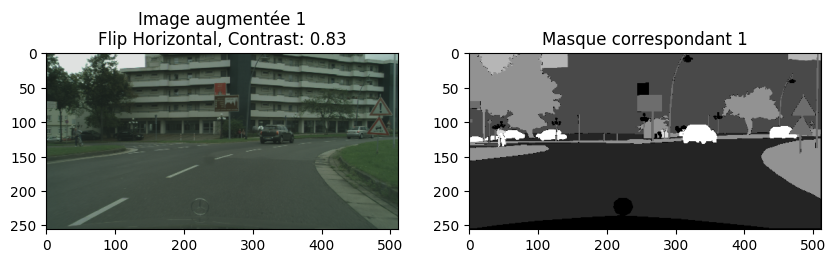

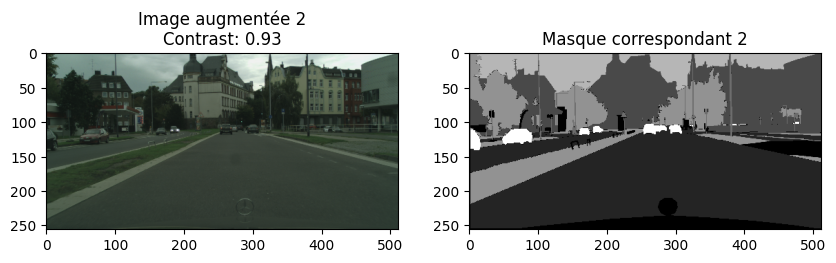

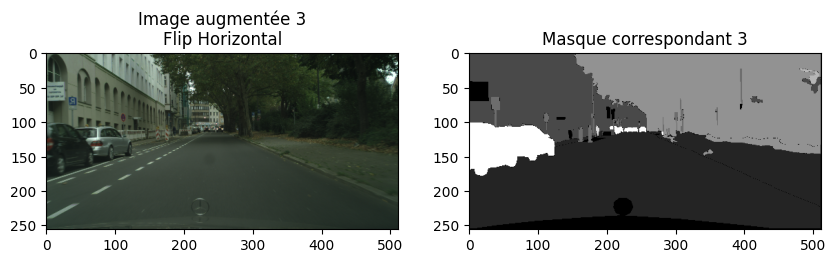

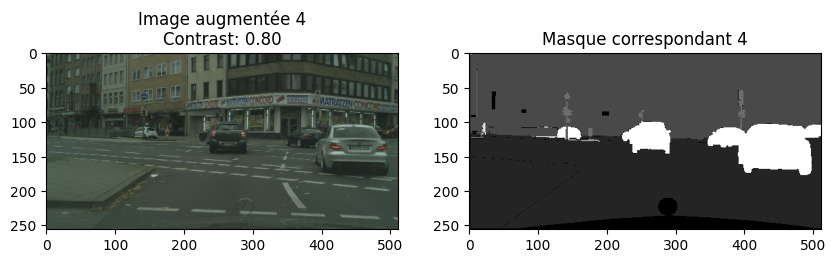

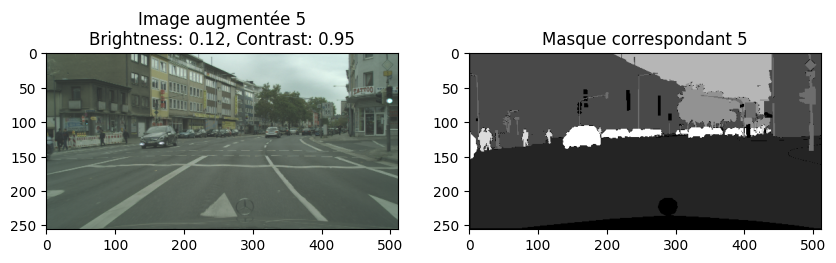

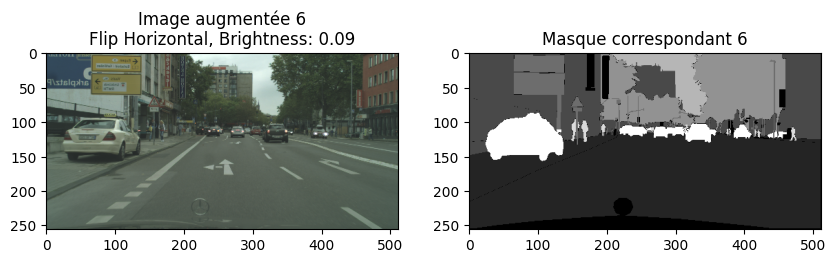

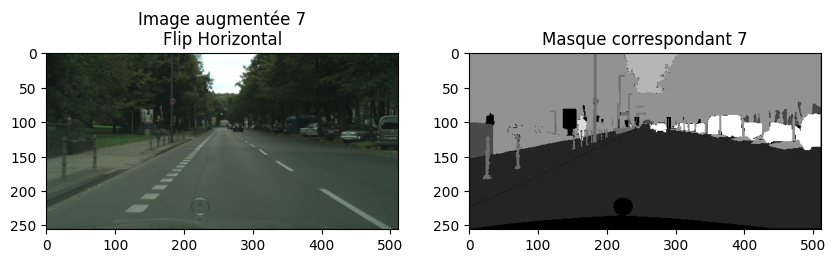

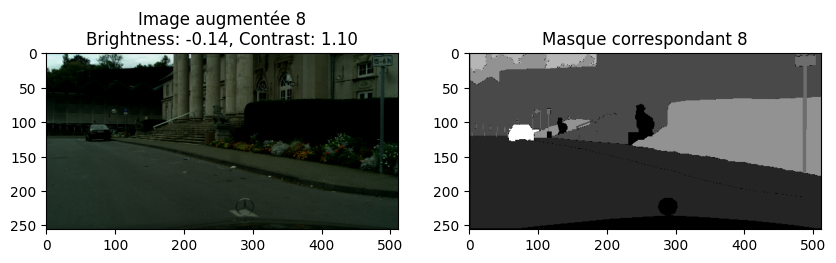

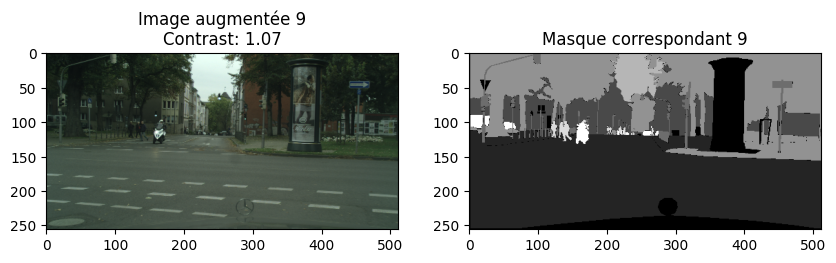

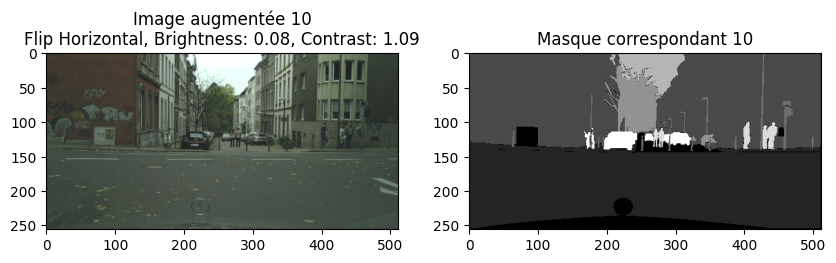

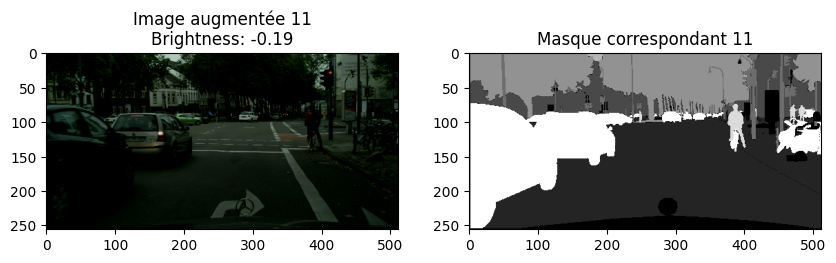

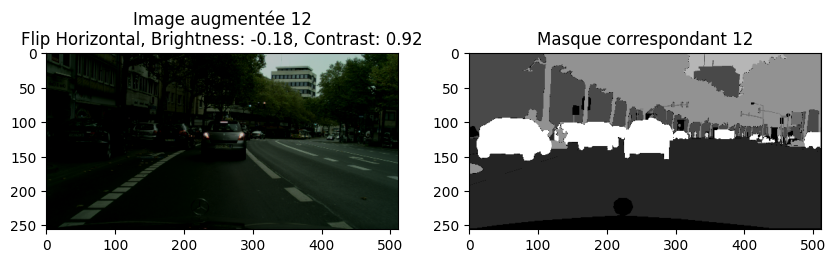

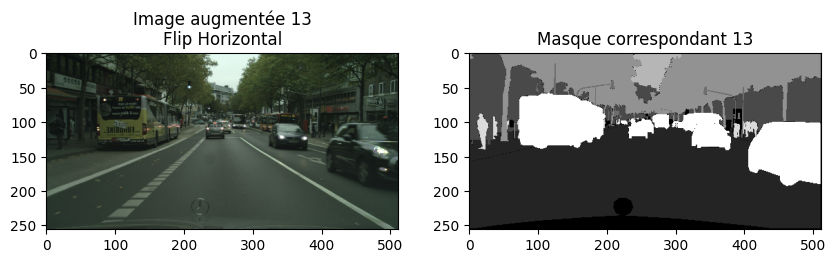

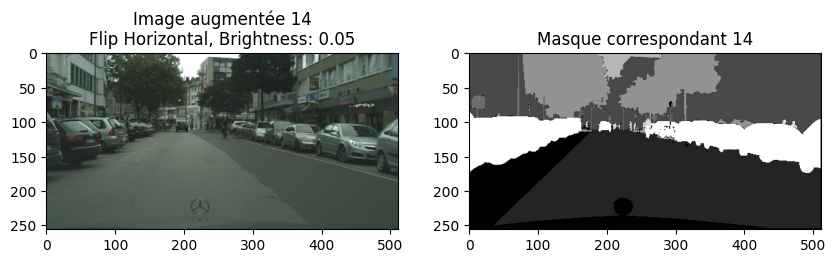

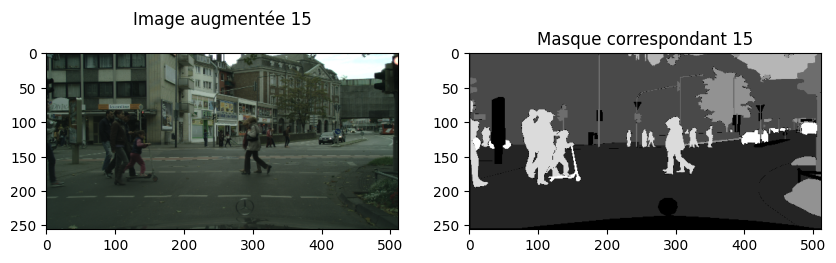

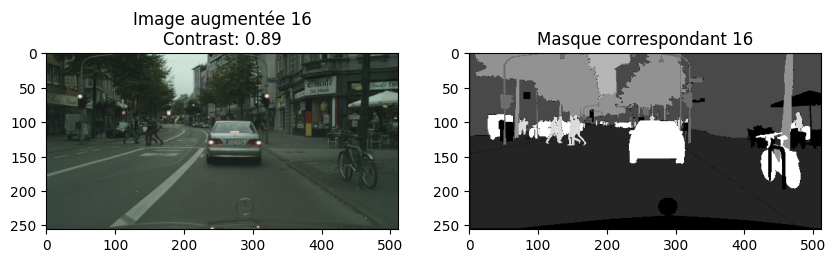

In [8]:
# Charger un lot d'images et de masques
images, masks = train_generator_with_aug[0]

# Visualiser toutes les images et leurs masques avec les augmentations appliquées
for i in range(len(images)):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Image augmentée {i+1}\n{train_generator_with_aug.augmentation_tags[i]}")
    plt.imshow(images[i])  # Affiche l'image augmentée
    plt.subplot(1, 2, 2)

    # Convertir le masque en classes (canal unique)
    mask_single_channel = tf.argmax(masks[i], axis=-1)  # Réduit la dimension (256, 512, 8) -> (256, 512)
    plt.title(f"Masque correspondant {i+1}")
    plt.imshow(mask_single_channel, cmap="gray")  # Affiche le masque converti
    plt.show()

## Métriques et pertes pour la segmentation multi-classe

Dans le cadre de la segmentation multi-classe, il est essentiel d’utiliser des métriques et des fonctions de perte adaptées. Nous allons définir :

### Métriques
1. **Dice Coefficient (`dice_metric`)** :
   - Permet de mesurer la similarité entre les pixels prédits et les pixels réels pour chaque classe.
   - Cette métrique est particulièrement utile pour gérer les déséquilibres entre les classes.

2. **Intersection over Union (IoU, `iou_metric`)** :
   - Évalue la qualité de la segmentation en calculant l’intersection sur l’union des pixels prédits et réels pour chaque classe.

### Fonctions de perte
1. **Dice Loss (`dice_loss`)** :
   - Utilisée pour minimiser les différences entre les prédictions et les vérités terrain.
   - Particulièrement efficace pour améliorer la segmentation des classes minoritaires.

2. **Combinaison Dice + Binary Crossentropy Loss (`dice_bce_loss`)** :
   - Combine les avantages de la Binary Crossentropy et de la Dice Loss.
   - Cela permet d’optimiser les performances globales tout en ciblant les détails des classes minoritaires.

Ces métriques et pertes sont particulièrement adaptées à une segmentation multi-classe, garantissant une évaluation précise et une optimisation efficace des performances du modèle.

In [4]:
@tf.keras.utils.register_keras_serializable()
def dice_metric(y_true, y_pred):
    """
    Calculer le Dice Coefficient pour une segmentation multi-classe.
    """
    dice_per_class = []
    for c in range(y_true.shape[-1]):  # Itérer sur les classes
        true_c = y_true[..., c]
        pred_c = y_pred[..., c]
        intersection = tf.reduce_sum(true_c * pred_c, axis=[1, 2])
        dice = (2. * intersection) / (
            tf.reduce_sum(true_c, axis=[1, 2]) + tf.reduce_sum(pred_c, axis=[1, 2]) + tf.keras.backend.epsilon()
        )
        dice_per_class.append(dice)

    return tf.reduce_mean(tf.stack(dice_per_class))

@tf.keras.utils.register_keras_serializable()
def iou_metric(y_true, y_pred):
    """
    Calculer le IoU pour une segmentation multi-classe.
    """
    iou_per_class = []
    for c in range(y_true.shape[-1]):  # Itérer sur les classes
        true_c = y_true[..., c]
        pred_c = y_pred[..., c]

        intersection = tf.reduce_sum(true_c * pred_c, axis=[1, 2])
        union = tf.reduce_sum(true_c, axis=[1, 2]) + tf.reduce_sum(pred_c, axis=[1, 2]) - intersection
        iou = intersection / (union + tf.keras.backend.epsilon())
        iou_per_class.append(iou)

    return tf.reduce_mean(tf.stack(iou_per_class))

@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    """
    Calculer le Dice Loss pour une segmentation multi-classe.
    """
    smooth = 1e-6
    dice_per_class = []
    for c in range(y_true.shape[-1]):  # Itérer sur les classes
        true_c = y_true[..., c]
        pred_c = y_pred[..., c]
        intersection = tf.reduce_sum(true_c * pred_c)
        union = tf.reduce_sum(true_c) + tf.reduce_sum(pred_c)
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_per_class.append(1 - dice)  # 1 - dice pour obtenir la perte

    return tf.reduce_mean(tf.stack(dice_per_class))

@tf.keras.utils.register_keras_serializable()
def dice_bce_loss(y_true, y_pred):
    """
    Combinaison de Binary Crossentropy Loss et Dice Loss pour une segmentation multi-classe.
    """
    bce = tf.keras.losses.BinaryCrossentropy()
    bce_loss = bce(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce_loss + dice

## Construction du modèle U-Net

Le modèle U-Net est un réseau convolutif conçu pour la segmentation d'images. Il est basé sur une architecture en forme de "U" qui combine un encodeur, un goulot d'étranglement (bottleneck) et un décodeur. Cette structure permet de capturer à la fois des caractéristiques globales et locales pour une segmentation précise.

### Architecture
1. **Encodeur** :
   - Composé de convolutions successives et de couches de max-pooling pour réduire progressivement la taille spatiale tout en augmentant la profondeur.
   - Permet d’extraire des caractéristiques de haut niveau.

2. **Bottleneck** :
   - Zone centrale qui agit comme un pont entre l'encodeur et le décodeur.
   - Utilise des convolutions avec une profondeur élevée pour capturer des représentations globales.

3. **Décodeur** :
   - Composé de couches d'upsampling et de concaténations pour reconstruire la résolution d’origine.
   - Combine des caractéristiques extraites à différents niveaux de l’encodeur avec celles du décodeur.

4. **Sortie** :
   - Une couche de convolution avec une activation `softmax` qui génère une probabilité pour chaque classe sur chaque pixel.

### Caractéristiques
- **Input** : Images d’entrée de dimensions `(256, 512, 3)`.
- **Output** : Masques segmentés avec 8 classes distinctes.
- **Dropout** : Ajouté dans le bottleneck pour réduire le sur-apprentissage.
- **Optimisation** : Une activation `relu` est utilisée pour chaque couche convolutive sauf en sortie, où `softmax` est appliqué.

Ce modèle constitue une base solide pour la segmentation multi-classe dans le cadre de ce projet.

In [9]:
def build_unet(input_shape=(256, 512, 3), num_classes=8):
    """
    Construire un modèle U-Net pour la segmentation multi-classe.
    Args:
        input_shape (tuple): Dimensions des images en entrée (hauteur, largeur, canaux).
        num_classes (int): Nombre de classes pour la segmentation.
    Returns:
        model (tf.keras.Model): Modèle U-Net non compilé.
    """
    # Entrée
    inputs = Input(shape=input_shape)

    # Encodeur
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    bn = Dropout(0.5)(bn)
    bn = Conv2D(1024, (3, 3), activation='relu', padding='same')(bn)

    # Décodeur
    u1 = UpSampling2D((2, 2))(bn)
    u1 = Concatenate()([u1, c4])
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = Concatenate()([u2, c3])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = Concatenate()([u3, c2])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u4 = UpSampling2D((2, 2))(c7)
    u4 = Concatenate()([u4, c1])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    # Sortie
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c8)

    # Modèle
    model = Model(inputs, outputs)
    return model

## Configuration du modèle U-Net

Nous définissons ici le modèle U-Net qui sera utilisé pour la segmentation multi-classe. Le modèle est construit avec des dimensions d’entrée adaptées à notre jeu de données et compilé avec un optimiseur Adam, une fonction de perte combinée (Dice + Binary Crossentropy) et des métriques spécifiques (Dice, IoU et précision). Cette étape est cruciale pour finaliser la structure et les paramètres d’entraînement avant de passer à la phase d’entraînement proprement dite.

In [10]:
# Construire le modèle
unet_model = build_unet(input_shape=(256, 512, 3), num_classes=8)

# Compiler le modèle
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=dice_bce_loss,
    metrics=[dice_metric, iou_metric, 'accuracy']
)

# Afficher le résumé
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 512,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 128,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 128,   │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 128,   │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 64,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 64,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 32,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 32,    │          0 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 32,    │  9,438,208 │ dropout[0][0]     │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 31,379,400 (119.70 MB)

 Trainable params: 31,379,400 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

## Gestion des répertoires de modèles

Pour organiser les sauvegardes des modèles entraînés, nous définissons une fonction permettant de créer dynamiquement des répertoires en fonction du nom du modèle et du type d'entraînement (par exemple, avec ou sans augmentations). Ces répertoires garantiront une gestion claire et structurée des fichiers générés lors des différentes phases d'entraînement.

In [8]:
# Paramètres globaux
BASE_MODEL_DIR = "models"

def create_model_directory(model_name, training_type):
    """
    Crée un répertoire basé sur le nom du modèle et le type d'entraînement.
    Args:
        model_name (str): Nom du modèle (e.g., "unet", "unet_vgg16", "yolo").
        training_type (str): Type d'entraînement (e.g., "no_aug", "with_aug").
    Returns:
        str: Chemin complet du répertoire créé.
    """
    dir_name = os.path.join(BASE_MODEL_DIR, model_name, training_type)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        print(f"Dossier créé : {dir_name}")
    else:
        print(f"Dossier déjà existant : {dir_name}")
    return dir_name

## Configuration des callbacks

Pour superviser et optimiser l’entraînement, nous allons configurer plusieurs callbacks :

- **ModelCheckpoint** : Ce callback sauvegarde les modèles à plusieurs étapes :
  - Le meilleur modèle, basé sur la perte de validation (`val_loss`), est enregistré sous le nom `best_model.keras`. Cela permet de garantir une version optimale du modèle, même si l’entraînement se poursuit.
  - Les modèles intermédiaires sont sauvegardés après chaque époque, avec des noms uniques contenant le numéro de l’époque. Cela prévient toute perte de données en cas d’interruption prématurée.

- **EarlyStopping** : Ce mécanisme interrompt automatiquement l’entraînement si la perte de validation ne s’améliore pas après un certain nombre d’époques consécutives (défini par `patience`). Cela permet d’économiser du temps de calcul et d’éviter le sur-apprentissage.

- **ReduceLROnPlateau** : Si la perte de validation stagne, ce callback réduit dynamiquement le taux d’apprentissage de l’optimiseur, permettant au modèle de continuer à converger avec un ajustement plus fin.

- **TensorBoard** : Ce callback enregistre des journaux détaillés pour visualiser les performances de l’entraînement (courbes de perte, métriques, etc.) à l’aide de TensorBoard. Il est particulièrement utile pour analyser le comportement du modèle.

En combinant ces callbacks, nous assurons une gestion rigoureuse et efficace de l’entraînement, tout en maximisant les performances du modèle.

In [9]:
def get_callbacks(output_dir):
    """
    Génère une liste de callbacks pour l'entraînement.
    Args:
        output_dir (str): Répertoire pour sauvegarder les modèles et les logs.
    Returns:
        list: Liste des callbacks pour l'entraînement.
    """
    return [
        # Sauvegarde du meilleur modèle basé sur val_loss
        ModelCheckpoint(
            filepath=os.path.join(output_dir, "best_model.keras"),
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
            mode="min",
            verbose=1
        ),
        # Sauvegarde après chaque époque
        ModelCheckpoint(
            filepath=os.path.join(output_dir, "model_epoch_{epoch:02d}.keras"),
            save_weights_only=False,
            save_best_only=False,
            mode="auto",
            verbose=1
        ),
        # Arrêt précoce pour éviter un sur-apprentissage
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            mode="min",
            restore_best_weights=True,
            verbose=1
        ),
        # Réduction dynamique du taux d’apprentissage si stagnation
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            mode="min",
            min_lr=1e-6,
            verbose=1
        ),
        # TensorBoard pour visualiser l'entraînement
        TensorBoard(
            log_dir=os.path.join(output_dir, "logs"),
            histogram_freq=1,
            write_graph=True,
            write_images=True,
            update_freq="epoch"
        )
    ]

## Entraînement du modèle U-Net sans augmentations

Nous allons entraîner le modèle U-Net sur les données brutes, sans appliquer de transformations ou d'augmentations. Cela permettra de mesurer ses performances de base avant d'explorer les effets des augmentations.

Pendant cette étape :
- Un répertoire dédié sera créé pour sauvegarder les modèles générés.
- Les callbacks configurés précédemment superviseront l’entraînement.
- Le temps total d’entraînement sera mesuré pour évaluer les performances temporelles.

Ce premier entraînement pose une base de référence indispensable pour comparer les futurs résultats avec et sans augmentations.

In [10]:
# Définir le nombre d'époques
epochs = 10

In [15]:
# Entraîner U-Net sans augmentations
print("Entraînement du modèle U-Net sans augmentations...")

# Créer le répertoire pour sauvegarder le modèle
output_dir_unet_no_aug = create_model_directory("unet", "no_aug")

# Préparer les callbacks
callbacks_unet_no_aug = get_callbacks(output_dir_unet_no_aug)

# Mesurer le temps d'entraînement
start_time = time.time()

# Entraîner le modèle
history_unet_no_aug = unet_model.fit(
    train_generator_no_aug,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks_unet_no_aug,
    verbose=1
)

# Calculer le temps d'entraînement
end_time = time.time()
print(f"Temps d'entraînement (U-Net sans augmentations) : {end_time - start_time:.2f} secondes.")

Entraînement du modèle U-Net sans augmentations...
Dossier déjà existant : models\unet\no_aug
Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4000 - dice_metric: 0.1621 - iou_metric: 0.1041 - loss: 1.2220
Epoch 1: val_loss improved from inf to 0.80383, saving model to models\unet\no_aug\best_model.keras

Epoch 1: saving model to models\unet\no_aug\model_epoch_01.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 1792s 10s/step - accuracy: 0.4006 - dice_metric: 0.1626 - iou_metric: 0.1045 - loss: 1.2210 - val_accuracy: 0.6240 - val_dice_metric: 0.3694 - val_iou_metric: 0.2767 - val_loss: 0.8038 - learning_rate: 1.0000e-04
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6384 - dice_metric: 0.3875 - iou_metric: 0.2943 - loss: 0.7805
Epoch 2: val_loss improved from 0.80383 to 0.65294, saving model to models\unet\no_aug\best_model.keras

Epoch 2: saving model to models\unet\no_aug\model_epoch_02.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 1784s 10s/step - accuracy: 0.6386 - dice_me

## Résultats d'entraînement U-Net (sans augmentations)

L'entraînement du modèle U-Net sans pipeline d'augmentation de données montre des résultats encourageants sur le jeu de données. Voici les points clés à retenir :

- **Progression stable des métriques** : Le modèle a atteint un Dice Coefficient de ~0.66 (train) et ~0.64 (val), ainsi qu'un IoU moyen de ~0.57 (train) et ~0.55 (val). Ces résultats indiquent une segmentation cohérente et efficace.
- **Pas de surapprentissage détecté** : Les courbes d'entraînement et de validation sont proches, et la loss diminue régulièrement, suggérant une bonne généralisation.
- **Performances globales** : En l'absence d'augmentations, le modèle s'est bien adapté au jeu de données, atteignant un IoU > 0.50, ce qui est notable pour une segmentation multi-classes.

Ces résultats constituent une étape clé dans le développement du modèle, offrant une première validation des performances de la segmentation avec ce jeu de données.

## Entraînement du modèle U-Net avec augmentations

Après avoir établi une référence avec les données brutes, nous allons entraîner le modèle U-Net en utilisant des données augmentées. L’objectif est d’évaluer l’impact des transformations (flip horizontal, ajustements de luminosité, etc.) sur les performances du modèle.

Comme pour l’entraînement précédent :
- Un répertoire dédié sera créé pour sauvegarder les modèles associés à cet entraînement.
- Les callbacks superviseront le processus pour optimiser et sécuriser l’entraînement.
- Le temps total sera mesuré afin de comparer les durées avec et sans augmentations.

Cet entraînement nous permettra de déterminer si les augmentations améliorent la robustesse et les performances du modèle.

In [16]:
# Entraîner U-Net avec augmentations
print("\nEntraînement du modèle U-Net avec augmentations...")

# Créer le répertoire pour sauvegarder le modèle
output_dir_unet_with_aug = create_model_directory("unet", "with_aug")

# Préparer les callbacks
callbacks_unet_with_aug = get_callbacks(output_dir_unet_with_aug)

# Mesurer le temps d'entraînement
start_time = time.time()

# Entraîner le modèle
history_unet_with_aug = unet_model.fit(
    train_generator_with_aug,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks_unet_with_aug,
    verbose=1
)

# Calculer le temps d'entraînement
end_time = time.time()
print(f"Temps d'entraînement (U-Net avec augmentations) : {end_time - start_time:.2f} secondes.")


Entraînement du modèle U-Net avec augmentations...
Dossier créé : models\unet\with_aug
Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8506 - dice_metric: 0.6340 - iou_metric: 0.5362 - loss: 0.3938
Epoch 1: val_loss improved from inf to 0.37462, saving model to models\unet\with_aug\best_model.keras

Epoch 1: saving model to models\unet\with_aug\model_epoch_01.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 1720s 9s/step - accuracy: 0.8507 - dice_metric: 0.6340 - iou_metric: 0.5363 - loss: 0.3937 - val_accuracy: 0.8614 - val_dice_metric: 0.6552 - val_iou_metric: 0.5577 - val_loss: 0.3746 - learning_rate: 1.0000e-04
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8655 - dice_metric: 0.6571 - iou_metric: 0.5603 - loss: 0.3587
Epoch 2: val_loss improved from 0.37462 to 0.35555, saving model to models\unet\with_aug\best_model.keras

Epoch 2: saving model to models\unet\with_aug\model_epoch_02.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 1717s 9s/step - accuracy: 0.8655 - dice_me

## Résultats d'entraînement U-Net (avec augmentations)

L'entraînement du modèle U-Net avec un pipeline d'augmentations de données a permis d'améliorer significativement les performances par rapport à l'entraînement sans augmentations. Voici les points essentiels :

- **Amélioration des métriques** : Le Dice Coefficient a atteint ~0.70 (val), avec un IoU moyen de ~0.61 (val), marquant des gains notables (+6 points chacun) par rapport à l'entraînement précédent. La loss a également diminué, atteignant ~0.31 en validation.
- **Stabilité des performances** : Les courbes train/val restent cohérentes, sans signe de surapprentissage, et l'évolution des métriques reste régulière jusqu'à la dernière époque.
- **Impact des augmentations** : L'ajout d'augmentations a permis une meilleure généralisation aux variations de la scène.

Ces résultats confirment que le modèle bénéficie d'un entraînement enrichi par les augmentations.

## Construction et compilation du modèle U-Net avec VGG16

Nous allons construire un modèle U-Net en utilisant VGG16 comme backbone. Cette approche tire parti de la capacité de VGG16 à extraire des caractéristiques riches tout en intégrant les avantages structurels du U-Net pour la segmentation multi-classe. Le modèle sera compilé avec les mêmes paramètres que pour le U-Net classique afin de garantir une comparaison équitable.

In [12]:
def build_unet_vgg16(input_shape=(256, 512, 3), num_classes=8):
    """
    Construire un modèle U-Net avec VGG16 comme backbone pour la segmentation multi-classe.
    Args:
        input_shape (tuple): Dimensions des images en entrée (hauteur, largeur, canaux).
        num_classes (int): Nombre de classes pour la segmentation.
    Returns:
        model (tf.keras.Model): Modèle U-Net avec VGG16 backbone non compilé.
    """
    # Charger le backbone VGG16 pré-entraîné sans la couche top
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Geler les couches du backbone
    for layer in vgg16.layers:
        layer.trainable = False

    # Extraire les couches d'encodage
    c1 = vgg16.get_layer("block1_conv2").output
    c2 = vgg16.get_layer("block2_conv2").output
    c3 = vgg16.get_layer("block3_conv3").output
    c4 = vgg16.get_layer("block4_conv3").output
    c5 = vgg16.get_layer("block5_conv3").output

    # Bottleneck
    bn = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    bn = Dropout(0.5)(bn)
    bn = Conv2D(1024, (3, 3), activation='relu', padding='same')(bn)

    # Décodeur
    u1 = UpSampling2D((2, 2))(bn)
    u1 = Concatenate()([u1, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u2 = UpSampling2D((2, 2))(c6)
    u2 = Concatenate()([u2, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u3 = UpSampling2D((2, 2))(c7)
    u3 = Concatenate()([u3, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u4 = UpSampling2D((2, 2))(c8)
    u4 = Concatenate()([u4, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Sortie
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    # Créer le modèle
    model = Model(inputs=vgg16.input, outputs=outputs)
    return model

In [13]:
# Construire le modèle U-Net avec VGG16 comme backbone
unet_vgg16_model = build_unet_vgg16(input_shape=(256, 512, 3), num_classes=8)

# Compiler le modèle
unet_vgg16_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=dice_bce_loss,
    metrics=[dice_metric, iou_metric, 'accuracy']
)

# Afficher le résumé
unet_vgg16_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 512,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 512,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 256,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 256,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 256,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 128,   │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 128,   │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 128,   │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 128,   │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 64,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 64,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 64,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 64,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 32,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 32,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 32,    │  2,359,808 │ block5_conv1[0][

 Total params: 41,408,712 (157.96 MB)

 Trainable params: 26,694,024 (101.83 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Entraînement du modèle U-Net avec VGG16 sans augmentations

Comme pour le U-Net classique, nous entraînons le modèle U-Net avec VGG16 sur des données brutes, sans appliquer de transformations. Cet entraînement de référence permettra de mesurer les performances du modèle sans enrichissement des données.

In [14]:
# Entraîner U-Net VGG16 sans augmentations
print("\nEntraînement du modèle U-Net VGG16 sans augmentations...")

# Créer le répertoire pour sauvegarder le modèle
output_dir_unet_vgg16_no_aug = create_model_directory("unet_vgg16", "no_aug")

# Préparer les callbacks
callbacks_unet_vgg16_no_aug = get_callbacks(output_dir_unet_vgg16_no_aug)

# Mesurer le temps d'entraînement
start_time = time.time()

# Entraîner le modèle
history_unet_vgg16_no_aug = unet_vgg16_model.fit(
    train_generator_no_aug,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks_unet_vgg16_no_aug,
    verbose=1
)

# Calculer le temps d'entraînement
end_time = time.time()
print(f"Temps d'entraînement (U-Net VGG16 sans augmentations) : {end_time - start_time:.2f} secondes.")


Entraînement du modèle U-Net VGG16 sans augmentations...
Dossier déjà existant : models\unet_vgg16\no_aug
Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6412 - dice_metric: 0.3800 - iou_metric: 0.2934 - loss: 0.8313
Epoch 1: val_loss improved from inf to 0.42848, saving model to models\unet_vgg16\no_aug\best_model.keras

Epoch 1: saving model to models\unet_vgg16\no_aug\model_epoch_01.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 1537s 8s/step - accuracy: 0.6418 - dice_metric: 0.3807 - iou_metric: 0.2940 - loss: 0.8300 - val_accuracy: 0.8356 - val_dice_metric: 0.6185 - val_iou_metric: 0.5146 - val_loss: 0.4285 - learning_rate: 1.0000e-04
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8512 - dice_metric: 0.6339 - iou_metric: 0.5323 - loss: 0.3951
Epoch 2: val_loss improved from 0.42848 to 0.40853, saving model to models\unet_vgg16\no_aug\best_model.keras

Epoch 2: saving model to models\unet_vgg16\no_aug\model_epoch_02.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 1532s 8

## Résultats d'entraînement U-Net VGG16 (sans augmentations)

L’entraînement du modèle U-Net VGG16 sans data augmentation démontre une progression rapide et stable grâce à l’utilisation du backbone préentraîné VGG16. Voici les faits marquants :

- **Effet du backbone VGG16** : Les métriques initiales, notamment le Dice (~0.62 val) et l’IoU (~0.51 val), montrent une généralisation rapide dès la première époque, réduisant ainsi la phase de warm-up.
- **Stabilité des performances** : Les courbes train/val sont proches tout au long des 10 époques, avec un Dice final de ~0.71 (val) et un IoU de ~0.62 (val), confirmant l’équilibre entre apprentissage et généralisation.
- **Convergence efficace** : La loss diminue rapidement (de ~0.43 à ~0.30 en validation) et reste cohérente entre train et val, signe d’une optimisation stable.

Ces résultats valident l’efficacité du U-Net VGG16 pour la segmentation sur le projet, même sans pipeline d’augmentation.

## Entraînement du modèle U-Net avec VGG16 avec augmentations

Nous entraînons maintenant le modèle U-Net avec VGG16 en utilisant des données augmentées. Cette étape permet d’évaluer les effets des transformations sur les performances du modèle, en particulier sur sa robustesse aux variations dans les données d’entrée.

In [15]:
# Entraîner U-Net VGG16 avec augmentations
print("\nEntraînement du modèle U-Net VGG16 avec augmentations...")

# Créer le répertoire pour sauvegarder le modèle
output_dir_unet_vgg16_with_aug = create_model_directory("unet_vgg16", "with_aug")

# Préparer les callbacks
callbacks_unet_vgg16_with_aug = get_callbacks(output_dir_unet_vgg16_with_aug)

# Mesurer le temps d'entraînement
start_time = time.time()

# Entraîner le modèle
history_unet_vgg16_with_aug = unet_vgg16_model.fit(
    train_generator_with_aug,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks_unet_vgg16_with_aug,
    verbose=1
)

# Calculer le temps d'entraînement
end_time = time.time()
print(f"Temps d'entraînement (U-Net VGG16 avec augmentations) : {end_time - start_time:.2f} secondes.")


Entraînement du modèle U-Net VGG16 avec augmentations...
Dossier déjà existant : models\unet_vgg16\with_aug
Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8951 - dice_metric: 0.7157 - iou_metric: 0.6225 - loss: 0.2729
Epoch 1: val_loss improved from inf to 0.31442, saving model to models\unet_vgg16\with_aug\best_model.keras

Epoch 1: saving model to models\unet_vgg16\with_aug\model_epoch_01.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 1514s 8s/step - accuracy: 0.8951 - dice_metric: 0.7157 - iou_metric: 0.6225 - loss: 0.2729 - val_accuracy: 0.8792 - val_dice_metric: 0.6967 - val_iou_metric: 0.6016 - val_loss: 0.3144 - learning_rate: 1.0000e-04
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8997 - dice_metric: 0.7215 - iou_metric: 0.6296 - loss: 0.2623
Epoch 2: val_loss improved from 0.31442 to 0.30389, saving model to models\unet_vgg16\with_aug\best_model.keras

Epoch 2: saving model to models\unet_vgg16\with_aug\model_epoch_02.keras
186/186 ━━━━━━━━━━━━━━━━━━

## Résultats d'entraînement U-Net VGG16 (avec augmentations)

L’entraînement du modèle U-Net VGG16 avec un pipeline d’augmentations de données montre des résultats encore meilleurs que sans augmentations. Voici les points clés :

- **Impact de la data augmentation** : Dès la première époque, le modèle atteint un Dice de ~0.70 et un IoU de ~0.60 en validation, ce qui reflète une meilleure généralisation grâce à la diversité artificielle des données.
- **Progression stable des métriques** : Le Dice final (~0.73 val) et l’IoU (~0.63 val) confirment une segmentation précise et robuste sur Cityscapes. L’accuracy atteint ~0.89 en validation, avec des pertes bien maîtrisées (val_loss de ~0.28).
- **Stabilité de l’entraînement** : Les courbes train/val restent proches, sans oscillations excessives ni signe de surapprentissage, tout en maintenant une amélioration constante.

Ces résultats valident l’efficacité combinée du backbone VGG16 et des augmentations pour une segmentation urbaine performante.

In [5]:
# Charger le modèle entraîné
model_path = "models/unet_vgg16/with_aug/best_model.keras"
model = load_model(model_path, custom_objects={
    'dice_bce_loss': dice_bce_loss,
    'dice_metric': dice_metric,
    'iou_metric': iou_metric
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


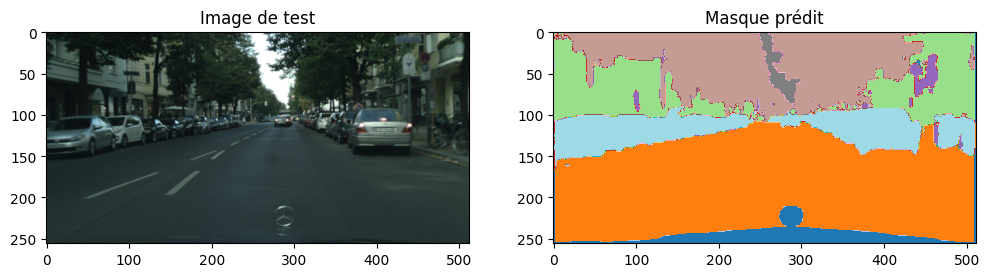

In [8]:
# Chemin de l'image de test
test_image_path = "data/test/images/berlin/berlin_000014_000019_leftImg8bit.png"

# Charger et prétraiter l'image de test
image = Image.open(test_image_path).resize((512, 256))  # Adapter la taille
image_array = np.array(image) / 255.0  # Normalisation
input_data = np.expand_dims(image_array, axis=0)  # Ajouter une dimension batch

# Prédire le masque
predicted_mask = model.predict(input_data)
predicted_mask = np.argmax(predicted_mask[0], axis=-1)  # Convertir en classes

# Afficher l'image et le masque
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Image de test")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Masque prédit")
plt.imshow(predicted_mask, cmap="tab20")  # Utiliser une palette de couleurs distinctes pour chaque classe
plt.show()